# Train SVR (Support Vector Regression) model on kss events

Train SVR and evaluate against training set

This is to verify the algorithms are working.
Validation is onde manually and will come later.


In [29]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import matplotlib.font_manager as mfm
from display import Disp
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline

from audio import Audio
from kss_df import KssDf
from transformers import SlidingWindow
from model_wrapper import TrainingLoader, ModelWrap, SharedParams, ModelPlot
from scorers import ConvVar

font_path = '/Users/dev/Fonts/Noto_Sans_KR/NotoSansKR-Regular.otf'
k_prop = mfm.FontProperties(fname=font_path)
plt.style.use('dark_background')

# Display handler with some nice helpers
disp = Disp(display)
# Uncomment to see the source code
# disp.code('display.py', label='display.py ')


# disp examples
# disp(IPython.display.Audio('./data/korean-single-speaker/kss/1/1_0000.wav'))
# disp_file_source('marker_df.py', label='marker_df')
# disp_audio_file('./data/korean-single-speaker/kss/1/1_0000.wav', label='1_0000.wav')

## Load Training Data

In [30]:
trn_loader = TrainingLoader('xy_trn_rms')
X_train, y_train, _ = trn_loader.load()

disp.obj(X_train, label='X')
disp.obj(y_train, label='y')
disp.obj((X_train.shape, np.mean(X_train)), label='X shape, mean' )
disp.obj((y_train.shape, np.mean(y_train)), label='y shape, mean')

X

array([7.2832445e-05, 8.1853534e-05, 8.1345970e-05, ..., 1.6493888e-03,
       1.9856682e-03, 2.1819461e-03], dtype=float32)

y

array([False, False, False, ..., False, False, False])

X shape, mean

((8895,), 0.23018801)

y shape, mean

((8895,), 0.818999437886453)

## Train Model and Save

We wrap the model in a pipeline as we need to do some transformations (creating windowed features for X).

In [31]:
from keras.models import Sequential
from keras import layers
import tensorflow as tf

def gaussian(x):
    return tf.exp(-tf.pow(x, 2.))

def bconvolve_tf(a1, a2):
    pn1 = tf.where(a1>0, 1, -1)
    pn2 = tf.where(a2>0, 1, -1)
    l = max(len(a1), len(a2))
    data   = tf.reshape(pn1, [1, int(pn1.shape[0]), 1], name='data')
    kernel = tf.reshape(pn2, [int(pn2.shape[0]), 1, 1], name='kernel')
    # print('data', data.dtype)
    # print('kernel', kernel.dtype)
    conv = tf.squeeze(tf.nn.conv1d(data, kernel, 1, 'VALID') / l)
    conv = tf.cast(conv, tf.float32)
    # print('conv b', conv.dtype)
    return  conv
    # return tf.max(np.convolve(pn1, pn2, mode='valid')) / l

def conv_var_tf(a1, a2, var_penalty=30):
    if not tf.is_tensor(a1):
        a1 = tf.constant(a1, dtype=tf.float64)
    if not tf.is_tensor(a2):
        a2 = tf.constant(a2, dtype=tf.float64)
    _, var1 = tf.nn.moments(a1, axes=[0])
    _, var2 = tf.nn.moments(a2, axes=[0])
    var_penalty = 30.0 # var_penalty default empirically chosen to give a decent sized penalty to differing variances
    var_diff = var1 - var2
    var_factor = gaussian(var_penalty * var_diff)
    # print('var_factor', var_factor)
    # print('bconvolve', bconvolve_tf(a1, a2))
    conv = bconvolve_tf(a1, a2) * var_factor
    # print('conv', conv)
    # tf.cast(conv, tf.float32)
    return conv

#     var_diff = np.var(a1) - np.var(a2)
#     # we apply a guassian to normalize the diff between 0 and 1. A diff of 0->1, A diff of ±inf->0
#     var_factor = gaussian(var_penalty*var_diff)
#     return bconvolve_score(a1, a2) * var_factor

def conv_loss(y_true, y_pred):
    # print('loss y true', y_true.dtype)
    # print('loss y pred', y_pred.dtype)
    return 1.0 - conv_var_tf(y_true, y_pred)

print('X,y shapes', X_train.shape, y_train.shape)

X,y shapes (8895,) (8895,)


SlidingWindow[INFO]: np sliding window shape: (9087, 128)


swX, swy shapes (8895, 128) (8895,)
X_cnn shape (8895, 128, 1)
input_shape (128, 1)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 126, 32)           128       
_________________________________________________________________
average_pooling1d_3 (Average (None, 5, 32)             0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 3, 64)             6208      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 6,401
Trainable params: 6,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
445/445 [==============

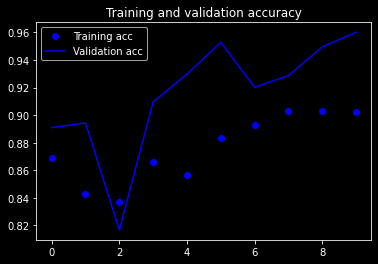

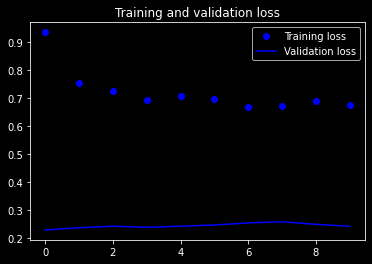

In [32]:
sw = SlidingWindow(window=128, offset_percent=0.75)

sw.fit_transform(X_train, y_train)

print('swX, swy shapes', sw.X.shape, sw.y.shape)
y_cnn = sw.y.astype('float64')
X_cnn = sw.X.reshape(sw.X.shape[0],sw.X.shape[1],1)
print('X_cnn shape', X_cnn.shape)
input_shape = (X_cnn.shape[1], X_cnn.shape[2])
print('input_shape', input_shape)
#parameters
kernel_size = 3
# optimizer=RMSprop(lr=1e-4)
optimizer='rmsprop'
strides=1


model = Sequential()
# model.add(layers.Embedding(X.shape[0], kernel_size, input_length=input_length))
model.add(layers.Conv1D(32, kernel_size, activation='relu', strides=strides, input_shape=input_shape))
model.add(layers.AveragePooling1D(24))
model.add(layers.Conv1D(64, kernel_size, activation='relu', strides=strides))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

# pass run_eagerly=True if there are problems converting Tensors <-> numpy
model.compile(optimizer=optimizer,
              # loss='binary_crossentropy',
              loss=conv_loss,
              metrics=['acc'],
              run_eagerly=True)

history = model.fit(X_cnn, y_cnn.astype('float32'),
                    epochs=10,
                    batch_size=16,
                    validation_split=0.2)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
# sliding_window = SlidingWindow()
# disp.obj(sliding_window, label='SlidingWindow')



# model_id = 'svr_rbf'
# svr_rbf = SVR(kernel='rbf')
#
# model_params = {
#     'svr_rbf__C': [50],
#     'svr_rbf__gamma': [0.2],
#     'svr_rbf__epsilon': [0.1]
# }
# m = ModelWrap('svr_rbf', svr_rbf, model_params, training_version=trn_loader.training_version)
# m.fit(X_train, y_train)
#
# print(f'Best parameter (CV score={m.search.best_score_:.3f}):')
# print(m.search.best_params_)
#
# saved_wrap = m.save()

## Evaluate Training

Evaluate the training data by seeing if our trained model will predict close to the data it was trained on.

Validation will come later

This is just to make sure our Model trained correctly. It might have overfit, but we don't care yet.

In [33]:
saved_wrap = model
y_train_pred = saved_wrap.predict(X_cnn)
shared_params = SharedParams().load()

In [34]:
kss_ids = shared_params['kss']['trn_ids']
print(kss_ids)
audio_params = shared_params['audio']
# iterate over each kss_id, find the audio file, load it and return it's squeezed rms
x_rms = np.concatenate([Audio(KssDf(id).audio_path, **audio_params).rms.squeeze() for id in kss_ids])

sw_mean_offset = sw.window-sw.offset
sw_offset = 0

/Users/dev/Projects/korean-ml/venv/lib/python3.9/site-packages/librosa/filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(
Audio[INFO]: a.to_rms size: 2431, reduction factor 2430.0
Audio[WARNING]: Modifying input wav from size 175173 to 175232
Audio[INFO]: change in number of samples: 59 [should be less than hop length: 64]
Audio[INFO]: a.to_rms size: 2739, reduction factor 2738.0
Audio[WARNING]: Modifying input wav from size 77573 to 77632
Audio[INFO]: change in number of samples: 59 [should be less than hop length: 64]
Audio[INFO]: a.to_rms size: 1214, reduction factor 1213.0
Audio[WARNING]: Modifying input wav from size 101762 to 101824
Audio[INFO]: change in number of samples: 62 [should be less than hop length: 64]
Audio[INFO]: a.to_rms size: 1592, reduction factor 1591.0
Audio[WARNING]: Modifying input wav from size 58741 to 58752
A

['1_0000', '1_0001', '1_0002', '1_0003', '1_0004']


In [35]:
# sw_pipe = Pipeline([('sw', m.pw.pipe.named_steps['sw'])])
# x_sw = sw_pipe.transform(X_train)

(8895, 1)


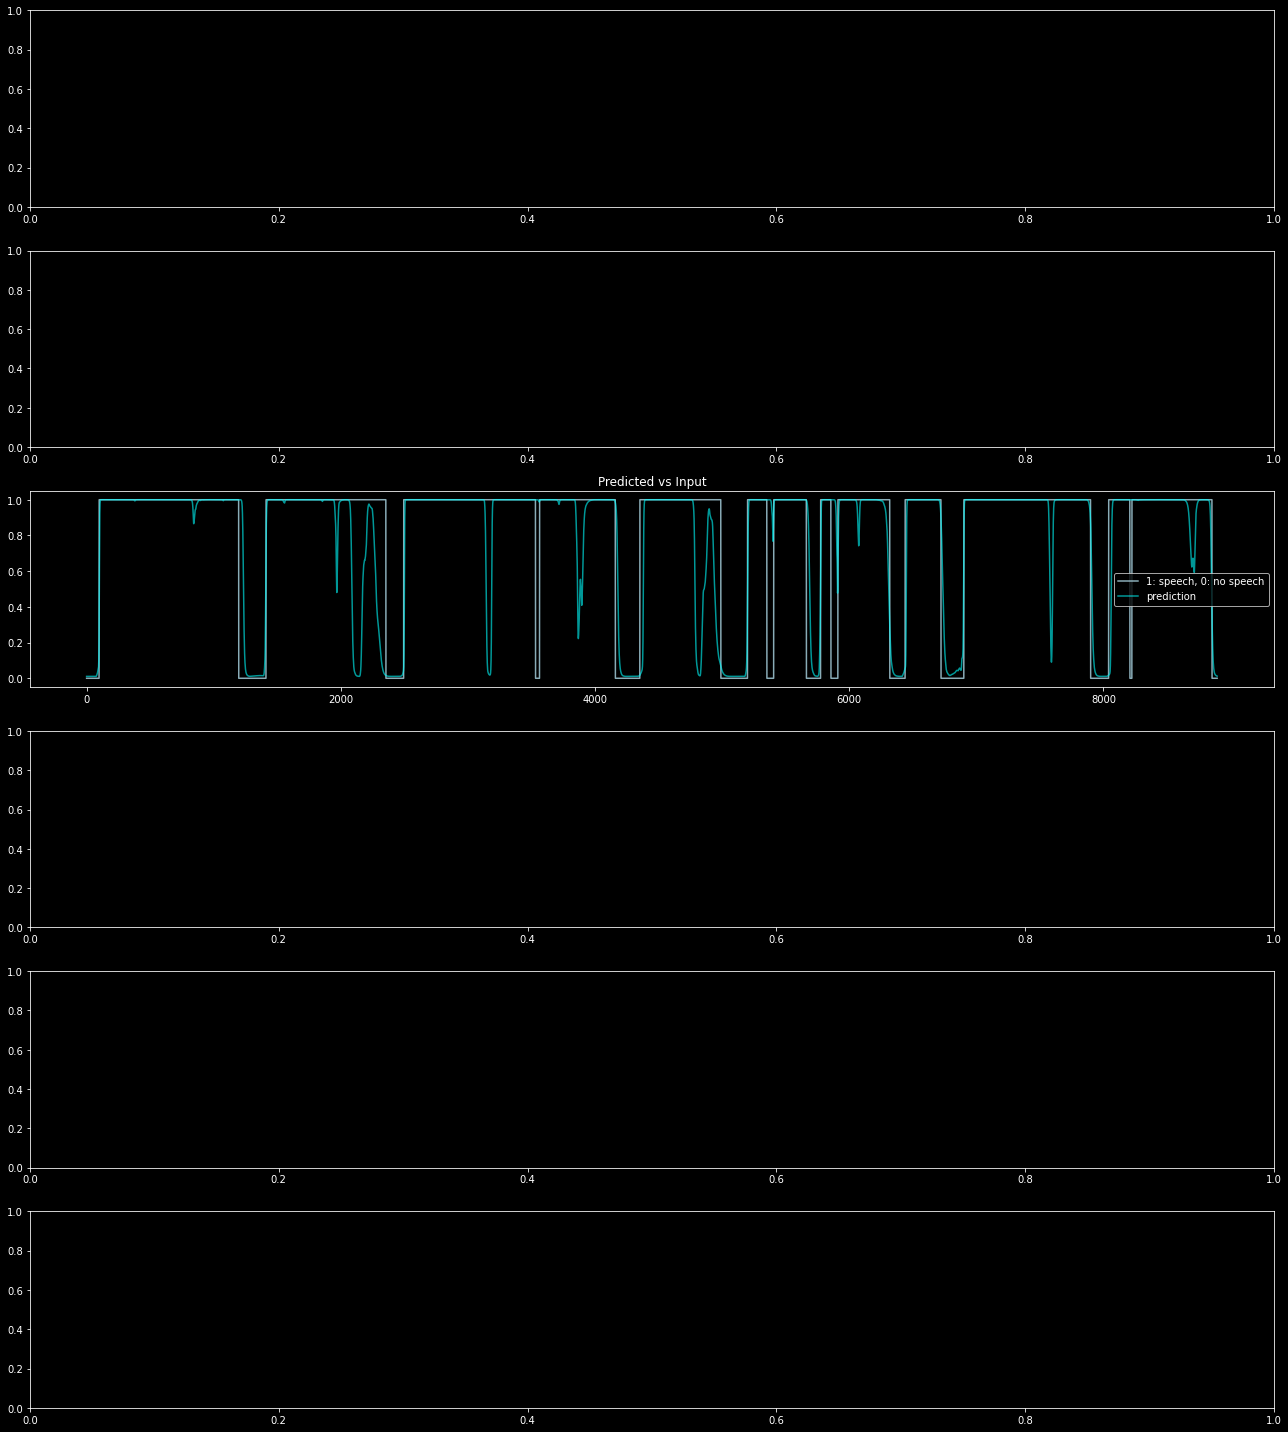

In [36]:
print(y_train_pred.shape)
# ModelPlot.plot(X_train, y_train, y_train_pred, sw_offset, x_rms, X_train, sw_mean_offset)

# def plot(X_train, y_train, y_train_pred, sw_offset, x_rms, x_sw, sw_mean_offset):
def plot(y_train, y_train_pred):
    fig, axs  = plt.subplots(6, 1, figsize=(18,20))
    # axs[0].set_title(f'Mean of Sliding Window')
    # axs[0].plot(X_train, color='lightblue', alpha=0.4, label='X')
    # axs[0].plot(X_train - x_rms, color='yellow', alpha=0.4, label='X-X_rms')
    # axs[0].plot(ModelPlot.align(np.mean(x_sw, axis=1), sw_mean_offset), color='cyan', alpha=0.6, label='sliding window mean (txfm X)')
    # axs[0].legend(loc='center right')
    #
    # axs[1].set_title(f'Speech/No Speech (manually identified)')
    # axs[1].plot(x_rms, color='slategray', alpha=0.4, label='rms of audio')
    # axs[1].plot(y_train, color='lightblue', alpha=0.8, label='1: speech, 0: no speech')
    # axs[1].legend(loc='center right')

    # axs[2].set_title(f'Predicted vs Input')
    # axs[2].plot(y_train, color='lightblue', alpha=0.8, label='1: speech, 0: no speech')
    # axs[2].plot(ModelPlot.align(y_train_pred, sw_offset), color='cyan', alpha=0.6, label='prediction')
    # axs[2].legend(loc='center right')

    axs[2].set_title(f'Predicted vs Input')
    axs[2].plot(y_train, color='lightblue', alpha=0.8, label='1: speech, 0: no speech')
    axs[2].plot(y_train_pred, color='cyan', alpha=0.6, label='prediction')
    axs[2].legend(loc='center right')

    # axs[3].set_title(f'Difference to base Speech/No Speech Input')
    # axs[3].plot(x_rms, color='slategray', alpha=0.3, label='rms of audio')
    # axs[3].plot(y_train.astype(int)-y_train.astype(int), color='yellow', alpha=0.8, label='base')
    # axs[3].plot(ModelPlot.speech_base_delta(y_train.astype(int), y_train, sw_offset), color='lightblue', alpha=0.8, label="padded to align")
    # axs[3].plot(ModelPlot.speech_base_delta(y_train_pred, y_train, sw_offset), color='thistle', alpha=0.5, label='pred delta')
    # axs[3].legend(loc='lower right')
    #
    # axs[4].set_title(f'Boolean Prediction')
    # axs[4].plot(x_rms, color='slategray', alpha=0.3, label='rms of audio')
    # axs[4].plot(1*ModelPlot.pred_threshold(y_train, 0.5), color='lime', alpha=0.4, label='manual')
    # axs[4].legend(loc='center right')
    #
    # axs[5].set_title(f'Prediction Deltas to Base')
    # axs[5].plot(ModelPlot.speech_base_delta(y_train_pred, y_train, sw_offset), color='thistle', alpha=0.5, label='pred vals - base')
    # axs[5].axhspan(-0.5, 0.5, color='lightblue', alpha=0.3, label='0.5 thresh'),
    # axs[5].axhspan(-0.75, 0.75, color='slategray', alpha=0.3, label='0.75 thresh')
    # axs[5].legend(loc='upper right')

    plt.tight_layout()
    plt.show()

plot(y_train, y_train_pred)


In [37]:
print(y_train.shape, y_train_pred.shape)

print(ConvVar().score(y_train.squeeze(), y_train_pred.squeeze()))

(8895,) (8895, 1)
0.592882926509069
